# Assignment 03 - Stock Price Prediction

In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch.optim as optim
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import torch.nn.functional as F
import warnings
warnings.filterwarnings("ignore")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## 1. Data and Functions

In [129]:
CAC40_raw = pd.read_csv('Data_CAC40.csv',parse_dates=['Date'])      
CAC40_raw

,Date,ticker_P,le cours d'ouverture_P,le plus haut_P,le plus bas_P,le cours de cl??ture_P,le volume de titres ??chang??s_P,Gtrends_P,nom_P,ISIN_P,ISIN_G,nom_G,Gtrends_G,le volume de titres ??chang??s_G,le cours de cl??ture_G,le plus haut_G,le plus bas_G,le cours d'ouverture_G,ticker_G
0,2017-03-01,AC,37.4950,37.5900,37.2250,37.5200,1199037,50.000000,Accor Hotels,FR0000120404,FR0003500008,CAC 40,41.000000,3995369,4960.83,4970.64,4897.48,4897.48,PX1
1,2017-03-01,GLE,42.6000,44.1850,42.5100,43.9700,6332074,90.000000,Societe Generale,FR0000130809,FR0003500008,CAC 40,41.000000,3995369,4960.83,4970.64,4897.48,4897.48,PX1
2,2017-03-01,ML,106.5500,107.8000,106.3500,107.3000,449706,79.000000,Michelin,FR0000121261,FR0003500008,CAC 40,41.000000,3995369,4960.83,4970.64,4897.48,4897.48,PX1
3,2017-03-01,FP,47.2500,47.8850,47.2500,47.7500,5646676,97.000000,Total,FR0000120271,FR0003500008,CAC 40,41.000000,3995369,4960.83,4970.64,4897.48,4897.48,PX1
4,2017-03-01,KER,215.0976,219.0017,215.0976,217.9792,274435,38.000000,Kering,FR0000121485,FR0003500008,CAC 40,41.000000,3995369,4960.83,4970.64,4897.48,4897.48,PX1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20435,2019-03-01,AIR,114.0600,114.3400,113.3400,113.9000,1263899,85.171807,Airbus,NL0000235190,FR0003500008,CAC 40,23.377503,3625033,5265.19,5286.69,5262.47,5267.14,PX1
20436,2019-03-01,KER,500.0000,500.8000,491.8000,495.5000,309691,50.217982,Kering,FR0000121485,FR0003500008,CAC 40,23.377503,3625033,5265.19,5286.69,5262.47,5267.14,PX1
20437,2019-03-01,SAF,119.8000,120.7000,119.6000,120.0000,769703,137.736770,Safran,FR0000073272,FR0003500008,CAC 40,23.377503,3625033,5265.19,5286.69,5262.47,5267.14,PX1
20438,2019-03-01,ACA,11.3420,11.3700,11.1300,11.1380,8024737,89.884578,Credit Agricole,FR0000045072,FR0003500008,CAC 40,23.377503,3625033,5265.19,5286.69,5262.47,5267.14,PX1


In [130]:
cols = ['Date','Ticker_P','Opening Price_P','Highest Price_P','Lowest Price_P','Closing Price_P','Trading Volume_P','Gtrends_P',
        'Name_P','ISIN_P','ISIN_G','Gtrends_G','Name_G','Trading Volume_G','Closing Price_G','Highest Price_G','Lowest Price_G',
        'Opening Price_G','Ticker_G']
CAC40_raw.columns = cols                                     
CAC40_raw.head(5)

,Date,Ticker_P,Opening Price_P,Highest Price_P,Lowest Price_P,Closing Price_P,Trading Volume_P,Gtrends_P,Name_P,ISIN_P,ISIN_G,Gtrends_G,Name_G,Trading Volume_G,Closing Price_G,Highest Price_G,Lowest Price_G,Opening Price_G,Ticker_G
0,2017-03-01,AC,37.4950,37.5900,37.2250,37.5200,1199037,50.0,Accor Hotels,FR0000120404,FR0003500008,CAC 40,41.0,3995369,4960.83,4970.64,4897.48,4897.48,PX1
1,2017-03-01,GLE,42.6000,44.1850,42.5100,43.9700,6332074,90.0,Societe Generale,FR0000130809,FR0003500008,CAC 40,41.0,3995369,4960.83,4970.64,4897.48,4897.48,PX1
2,2017-03-01,ML,106.5500,107.8000,106.3500,107.3000,449706,79.0,Michelin,FR0000121261,FR0003500008,CAC 40,41.0,3995369,4960.83,4970.64,4897.48,4897.48,PX1
3,2017-03-01,FP,47.2500,47.8850,47.2500,47.7500,5646676,97.0,Total,FR0000120271,FR0003500008,CAC 40,41.0,3995369,4960.83,4970.64,4897.48,4897.48,PX1
4,2017-03-01,KER,215.0976,219.0017,215.0976,217.9792,274435,38.0,Kering,FR0000121485,FR0003500008,CAC 40,41.0,3995369,4960.83,4970.64,4897.48,4897.48,PX1


In [131]:
CAC40 = CAC40_raw.copy()                                    
cols.insert(15,cols.pop(cols.index('Lowest Price_G')))        
temp = cols[10:20]                                            
temp.reverse()                                               
cols_final = cols[0:10]+temp                                
CAC40 = CAC40.loc[:,cols_final]                              
CAC40.head(5)

,Date,Ticker_P,Opening Price_P,Highest Price_P,Lowest Price_P,Closing Price_P,Trading Volume_P,Gtrends_P,Name_P,ISIN_P,Ticker_G,Opening Price_G,Highest Price_G,Lowest Price_G,Closing Price_G,Trading Volume_G,Name_G,Gtrends_G,ISIN_G
0,2017-03-01,AC,37.4950,37.5900,37.2250,37.5200,1199037,50.0,Accor Hotels,FR0000120404,PX1,4897.48,4970.64,4897.48,4960.83,3995369,41.0,CAC 40,FR0003500008
1,2017-03-01,GLE,42.6000,44.1850,42.5100,43.9700,6332074,90.0,Societe Generale,FR0000130809,PX1,4897.48,4970.64,4897.48,4960.83,3995369,41.0,CAC 40,FR0003500008
2,2017-03-01,ML,106.5500,107.8000,106.3500,107.3000,449706,79.0,Michelin,FR0000121261,PX1,4897.48,4970.64,4897.48,4960.83,3995369,41.0,CAC 40,FR0003500008
3,2017-03-01,FP,47.2500,47.8850,47.2500,47.7500,5646676,97.0,Total,FR0000120271,PX1,4897.48,4970.64,4897.48,4960.83,3995369,41.0,CAC 40,FR0003500008
4,2017-03-01,KER,215.0976,219.0017,215.0976,217.9792,274435,38.0,Kering,FR0000121485,PX1,4897.48,4970.64,4897.48,4960.83,3995369,41.0,CAC 40,FR0003500008


In [132]:
CAC40 = CAC40.sort_values(by=['Date','Ticker_P'])
CAC40 = CAC40.reset_index(drop=True) 
CAC40.head(5)

,Date,Ticker_P,Opening Price_P,Highest Price_P,Lowest Price_P,Closing Price_P,Trading Volume_P,Gtrends_P,Name_P,ISIN_P,Ticker_G,Opening Price_G,Highest Price_G,Lowest Price_G,Closing Price_G,Trading Volume_G,Name_G,Gtrends_G,ISIN_G
0,2017-03-01,AC,37.4950,37.5900,37.2250,37.5200,1199037,50.0,Accor Hotels,FR0000120404,PX1,4897.48,4970.64,4897.48,4960.83,3995369,41.0,CAC 40,FR0003500008
1,2017-03-01,ACA,11.5500,11.8950,11.5500,11.8100,10022435,88.0,Credit Agricole,FR0000045072,PX1,4897.48,4970.64,4897.48,4960.83,3995369,41.0,CAC 40,FR0003500008
2,2017-03-01,AI,93.4091,94.6364,93.1818,94.1364,1050933,82.0,Air Liquide,FR0000120073,PX1,4897.48,4970.64,4897.48,4960.83,3995369,41.0,CAC 40,FR0003500008
3,2017-03-01,AIR,69.6900,71.4000,69.6400,71.1200,2496301,99.0,Airbus,NL0000235190,PX1,4897.48,4970.64,4897.48,4960.83,3995369,41.0,CAC 40,FR0003500008
4,2017-03-01,ATO,111.6500,112.5000,109.5500,111.3000,387363,80.0,Atos,FR0000051732,PX1,4897.48,4970.64,4897.48,4960.83,3995369,41.0,CAC 40,FR0003500008


In [133]:
date_list = CAC40['Date'].unique()
Tiker_list = CAC40['Ticker_P'].unique()
print(date_list, len(date_list))
print(Tiker_list, len(Tiker_list))

['2017-03-01T00:00:00.000000000' '2017-03-02T00:00:00.000000000'
 '2017-03-03T00:00:00.000000000' '2017-03-06T00:00:00.000000000'
 '2017-03-07T00:00:00.000000000' '2017-03-08T00:00:00.000000000'
 '2017-03-09T00:00:00.000000000' '2017-03-10T00:00:00.000000000'
 '2017-03-13T00:00:00.000000000' '2017-03-14T00:00:00.000000000'
 '2017-03-15T00:00:00.000000000' '2017-03-16T00:00:00.000000000'
 '2017-03-17T00:00:00.000000000' '2017-03-20T00:00:00.000000000'
 '2017-03-21T00:00:00.000000000' '2017-03-22T00:00:00.000000000'
 '2017-03-23T00:00:00.000000000' '2017-03-24T00:00:00.000000000'
 '2017-03-27T00:00:00.000000000' '2017-03-28T00:00:00.000000000'
 '2017-03-29T00:00:00.000000000' '2017-03-30T00:00:00.000000000'
 '2017-03-31T00:00:00.000000000' '2017-04-03T00:00:00.000000000'
 '2017-04-04T00:00:00.000000000' '2017-04-05T00:00:00.000000000'
 '2017-04-06T00:00:00.000000000' '2017-04-07T00:00:00.000000000'
 '2017-04-10T00:00:00.000000000' '2017-04-11T00:00:00.000000000'
 '2017-04-12T00:00:00.000

In [134]:
class CustomDataset():
    def __init__(self, X, y):
        self.data = X
        self.target = y

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        X = self.data[idx]
        y = self.target[idx]
        return X, y

In [135]:
hid_dim = 256
layers = 1
direct = 1
seq_len_longer = 30
seq_len_medium = 10
seq_len_shorter = 1
class RNN(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.rnn = nn.LSTM(emb_dim, hid_dim, layers, batch_first=True)
        self.fc1 = nn.Linear(hid_dim, 10)
        self.fc2 = nn.Linear(10, 1)
        self.fc3 = nn.Linear(hid_dim, 1)
    
    def forward(self, x):
        x, _ = self.rnn(x)
        #x = self.fc1(F.relu(x[:,-1,:]))   
        #x = self.fc2(F.relu(x))
        x = self.fc3(x[:,-1,:])   
        return x

In [136]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)    
    num_batches = len(dataloader)     
    model.train()
    train_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.reshape(X.shape[0]).to(device)
        #print(X.shape,y.shape)
        optimizer.zero_grad()   
        
        pred = model(X).reshape(X.shape[0])
        #print(pred,pred.shape,y,y.shape)
        loss = loss_fn(pred, y)
        #print(pred.shape,y.shape)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()    
        #num_correct_pred += (pred.argmax(1) == y).type(torch.float).sum().item()
        
        if batch % 10 == 0:      
            loss, current = loss.item(), batch * len(X)  
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    train_loss /= num_batches
    #num_correct_pred /= size
    
    return train_loss #, num_correct_pred

In [137]:
def val(dataloader, model, loss_fn):
    size = len(dataloader.dataset)   
    num_batches = len(dataloader)     
    model.eval()                      
    val_loss = 0
    with torch.no_grad():         
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            val_loss += loss_fn(pred, y).item()   
            #num_correct_pred += (pred.argmax(1) == y).type(torch.float).sum().item()
    val_loss /= num_batches     
    #num_correct_pred /= size          
    print(f"Avg loss: {val_loss:>8f} \n")
    return val_loss #, num_correct_pred

In [138]:
loss_fn = nn.MSELoss()

## 2. Ind2Ind1

In [139]:
X = torch.zeros([len(date_list)])
y = torch.zeros([len(date_list)])

In [140]:
for i in range(len(date_list)):
    X[i] = torch.tensor(CAC40.loc[(CAC40['Date']==date_list[i])]['Opening Price_G'].unique(), dtype=torch.float)
    y[i] = torch.tensor(CAC40.loc[(CAC40['Date']==date_list[i])]['Opening Price_G'].unique(), dtype=torch.float)

In [141]:
y = y/1000

In [142]:
X_train = X[0:411]
X_val = X[411:461]
X_test = X[461:511]
y_train = y[0:411]
y_val = y[411:461]
y_test = y[461:511]

In [143]:
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = torch.tensor(scaler.fit_transform(X_train.reshape(-1, 1)), dtype=torch.float)
X_val = torch.tensor(scaler.transform(X_val.reshape(-1, 1)), dtype=torch.float)
X_test = torch.tensor(scaler.transform(X_test.reshape(-1, 1)), dtype=torch.float)

In [144]:
seq_len = seq_len_shorter
X_train_dataset = []
X_val_dataset = []
X_test_dataset = []
y_train_dataset = []
y_val_dataset = []
y_test_dataset = []
for i in range(seq_len,len(X_train)):
    X_train_dataset.append(X_train[i-seq_len:i]) 
    y_train_dataset.append(y_train[i])       
for i in range(seq_len,len(X_val)):
    X_val_dataset.append(X_val[i-seq_len:i])   
    y_val_dataset.append(y_val[i])       
for i in range(seq_len,len(X_val)):              
    X_test_dataset.append(X_test[i-seq_len:i])   
    y_test_dataset.append(y_test[i])        

In [145]:
train_dataset = CustomDataset(X_train_dataset, y_train_dataset)
val_dataset = CustomDataset(X_val_dataset, y_val_dataset)
test_dataset = CustomDataset(X_test_dataset, y_test_dataset)

In [146]:
batch_size = 4
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)    
test_dataloader_NS = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)   

In [147]:
model = RNN(emb_dim=1).to(device)
optimizer = optim.Adam(model.parameters())   #, lr = 0.1)

In [148]:
epoch = 20
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []
for i in range(epoch):
    print(f'epoch: {i+1}/{epoch}')
    train_loss = train(train_dataloader, model, loss_fn, optimizer)    
    val_loss = val(val_dataloader, model, loss_fn)                      
    train_loss_list.append(train_loss)
    #train_acc_list.append(train_acc)
    val_loss_list.append(val_loss)
    #val_acc_list.append(val_acc)
print("Done!")

epoch: 1/20
loss: 27.228878  [    0/  410]
loss: 27.017012  [   40/  410]
loss: 25.299849  [   80/  410]
loss: 24.560585  [  120/  410]
loss: 21.914074  [  160/  410]
loss: 19.207306  [  200/  410]
loss: 16.381931  [  240/  410]
loss: 13.089764  [  280/  410]
loss: 9.914400  [  320/  410]
loss: 6.576209  [  360/  410]
loss: 3.241522  [  400/  410]
Avg loss: 3.778776 

epoch: 2/20
loss: 2.335726  [    0/  410]
loss: 0.894933  [   40/  410]
loss: 0.272857  [   80/  410]
loss: 0.072058  [  120/  410]
loss: 0.134815  [  160/  410]
loss: 0.020331  [  200/  410]
loss: 0.129584  [  240/  410]
loss: 0.021703  [  280/  410]
loss: 0.201442  [  320/  410]
loss: 0.135137  [  360/  410]
loss: 0.106407  [  400/  410]
Avg loss: 0.392121 

epoch: 3/20
loss: 0.103651  [    0/  410]
loss: 0.128307  [   40/  410]
loss: 0.092242  [   80/  410]
loss: 0.100998  [  120/  410]
loss: 0.028722  [  160/  410]
loss: 0.124396  [  200/  410]
loss: 0.052329  [  240/  410]
loss: 0.069840  [  280/  410]
loss: 0.034060

<AxesSubplot:xlabel='epochs'>

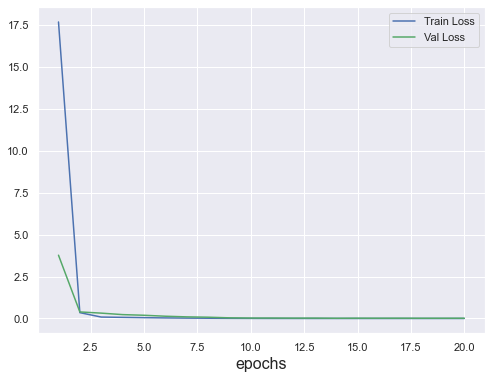

In [149]:
i = 0        
sns.set()
plt.figure(figsize=(8,6))
#plt.plot(range(1,epoch+1), train_acc_log[i], 'orange')
plt.plot(range(1,epoch+1), train_loss_list, 'b')
#plt.plot(range(1,epoch+1), val_acc_log[i], 'r')
plt.plot(range(1,epoch+1), val_loss_list, 'g')
plt.xlabel('epochs',fontsize=16)
plt.legend(['Train Loss','Val Loss'])
plt.grid(True)
plt.gca()#.set_ylim(0,5)

In [150]:
pred_list_1 = []
y_list_1 = []
model.eval()
with torch.no_grad():
    for batch, (X, y) in enumerate(test_dataloader):
        X, y = X.to(device), y
        pred = model(X)
        pred_list_1 = pred_list_1 + pred.cpu().detach().numpy().reshape(pred.shape[0]).tolist()
        y_list_1 = y_list_1 + y.numpy().tolist()
        #predicted = pred.argmax(axis=1)
        #total += y.shape[0]
        #correct += (predicted == y).sum().item()

In [151]:
pred_list_2 = []
y_list_2 = []
model.eval()
with torch.no_grad():
    for batch, (X, y) in enumerate(test_dataloader_NS):
        X, y = X.to(device), y
        pred = model(X)
        pred_list_2 = pred_list_2 + pred.cpu().detach().numpy().reshape(pred.shape[0]).tolist()
        y_list_2 = y_list_2 + y.numpy().tolist()
        #predicted = pred.argmax(axis=1)
        #total += y.shape[0]
        #correct += (predicted == y).sum().item()

<AxesSubplot:>

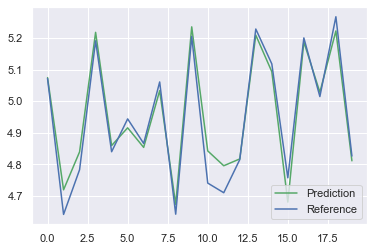

In [152]:
plt.plot(np.array(pred_list_1[-20:])*1, 'g')
plt.plot(np.array(y_list_1[-20:])*1, 'b')
plt.legend(['Prediction','Reference'])
plt.gca()#.set_ylim(49,53)

<AxesSubplot:>

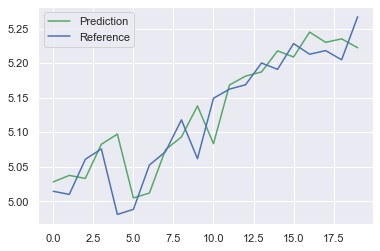

In [153]:
plt.plot(np.array(pred_list_2[-20:])*1, 'g')
plt.plot(np.array(y_list_2[-20:])*1, 'b')
plt.legend(['Prediction','Reference'])
plt.gca()#.set_ylim(0,6)

In [154]:
y_all = y_test[:30].tolist() + y_list_2[-20:]
pred_all = y_test[:30].tolist() + pred_list_2[-20:]

<AxesSubplot:>

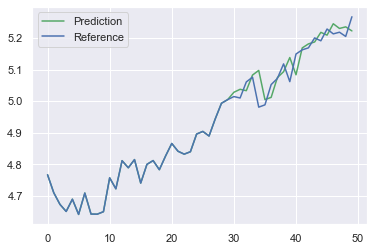

In [155]:
plt.plot(np.array(pred_all)*1, 'g')
plt.plot(np.array(y_all)*1, 'b')
plt.legend(['Prediction','Reference'])
plt.gca()#.set_ylim(0,6)

In [156]:
Ind2Ind1_mse = mean_squared_error(pred_list_2[-20:], y_list_2[-20:])
Ind2Ind1_mse_ave = mean_squared_error(pred_list_1, y_list_1)

## 3. Ind2Ind10

In [157]:
X = torch.zeros([len(date_list)])
y = torch.zeros([len(date_list)])

In [158]:
for i in range(len(date_list)):
    X[i] = torch.tensor(CAC40.loc[(CAC40['Date']==date_list[i])]['Opening Price_G'].unique(), dtype=torch.float)
    y[i] = torch.tensor(CAC40.loc[(CAC40['Date']==date_list[i])]['Opening Price_G'].unique(), dtype=torch.float)

In [159]:
y = y/1000

In [160]:
X_train = X[0:411]
X_val = X[411:461]
X_test = X[461:511]
y_train = y[0:411]
y_val = y[411:461]
y_test = y[461:511]

In [161]:
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = torch.tensor(scaler.fit_transform(X_train.reshape(-1, 1)), dtype=torch.float)
X_val = torch.tensor(scaler.transform(X_val.reshape(-1, 1)), dtype=torch.float)
X_test = torch.tensor(scaler.transform(X_test.reshape(-1, 1)), dtype=torch.float)

In [162]:
seq_len = seq_len_medium
X_train_dataset = []
X_val_dataset = []
X_test_dataset = []
y_train_dataset = []
y_val_dataset = []
y_test_dataset = []
for i in range(seq_len,len(X_train)):
    X_train_dataset.append(X_train[i-seq_len:i]) 
    y_train_dataset.append(y_train[i])        
for i in range(seq_len,len(X_val)):
    X_val_dataset.append(X_val[i-seq_len:i])   
    y_val_dataset.append(y_val[i])        
for i in range(seq_len,len(X_val)):             
    X_test_dataset.append(X_test[i-seq_len:i])   
    y_test_dataset.append(y_test[i])        

In [163]:
train_dataset = CustomDataset(X_train_dataset, y_train_dataset)
val_dataset = CustomDataset(X_val_dataset, y_val_dataset)
test_dataset = CustomDataset(X_test_dataset, y_test_dataset)

In [164]:
batch_size = 4
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)    
test_dataloader_NS = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)    

In [165]:
model = RNN(emb_dim=1).to(device)
optimizer = optim.Adam(model.parameters())#, lr = 0.1)

In [166]:
epoch = 20
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []
for i in range(epoch):
    print(f'epoch: {i+1}/{epoch}')
    train_loss = train(train_dataloader, model, loss_fn, optimizer)    
    val_loss = val(val_dataloader, model, loss_fn)                      
    train_loss_list.append(train_loss)
    #train_acc_list.append(train_acc)
    val_loss_list.append(val_loss)
    #val_acc_list.append(val_acc)
print("Done!")

epoch: 1/20
loss: 27.410246  [    0/  401]
loss: 20.279568  [   40/  401]
loss: 1.260219  [   80/  401]
loss: 0.241219  [  120/  401]
loss: 0.100034  [  160/  401]
loss: 0.012758  [  200/  401]
loss: 0.016178  [  240/  401]
loss: 0.059572  [  280/  401]
loss: 0.026262  [  320/  401]
loss: 0.019685  [  360/  401]
loss: 0.047309  [  100/  401]
Avg loss: 0.124915 

epoch: 2/20
loss: 0.028294  [    0/  401]
loss: 0.004795  [   40/  401]
loss: 0.019584  [   80/  401]
loss: 0.009125  [  120/  401]
loss: 0.003549  [  160/  401]
loss: 0.008985  [  200/  401]
loss: 0.033738  [  240/  401]
loss: 0.032680  [  280/  401]
loss: 0.027200  [  320/  401]
loss: 0.020324  [  360/  401]
loss: 0.005217  [  100/  401]
Avg loss: 0.175187 

epoch: 3/20
loss: 0.045212  [    0/  401]
loss: 0.067450  [   40/  401]
loss: 0.005767  [   80/  401]
loss: 0.022780  [  120/  401]
loss: 0.019941  [  160/  401]
loss: 0.035337  [  200/  401]
loss: 0.032875  [  240/  401]
loss: 0.050479  [  280/  401]
loss: 0.013882  [  3

<AxesSubplot:xlabel='epochs'>

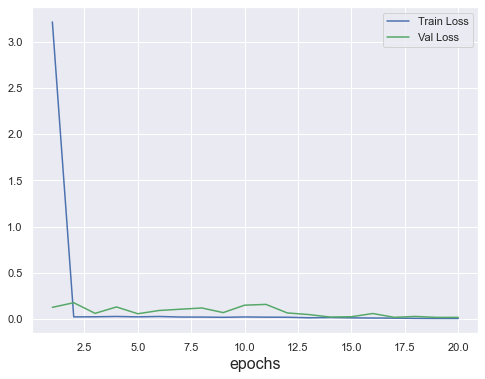

In [167]:
i = 0         
sns.set()
plt.figure(figsize=(8,6))
#plt.plot(range(1,epoch+1), train_acc_log[i], 'orange')
plt.plot(range(1,epoch+1), train_loss_list, 'b')
#plt.plot(range(1,epoch+1), val_acc_log[i], 'r')
plt.plot(range(1,epoch+1), val_loss_list, 'g')
plt.xlabel('epochs',fontsize=16)
plt.legend(['Train Loss','Val Loss'])
plt.grid(True)
plt.gca()#.set_ylim(0,5)

In [168]:
pred_list_1 = []
y_list_1 = []
model.eval()
with torch.no_grad():
    for batch, (X, y) in enumerate(test_dataloader):
        X, y = X.to(device), y
        pred = model(X)
        pred_list_1 = pred_list_1 + pred.cpu().detach().numpy().reshape(pred.shape[0]).tolist()
        y_list_1 = y_list_1 + y.numpy().tolist()
        #predicted = pred.argmax(axis=1)
        #total += y.shape[0]
        #correct += (predicted == y).sum().item()

In [169]:
pred_list_2 = []
y_list_2 = []
model.eval()
with torch.no_grad():
    for batch, (X, y) in enumerate(test_dataloader_NS):
        X, y = X.to(device), y
        pred = model(X)
        pred_list_2 = pred_list_2 + pred.cpu().detach().numpy().reshape(pred.shape[0]).tolist()
        y_list_2 = y_list_2 + y.numpy().tolist()
        #predicted = pred.argmax(axis=1)
        #total += y.shape[0]
        #correct += (predicted == y).sum().item()

<AxesSubplot:>

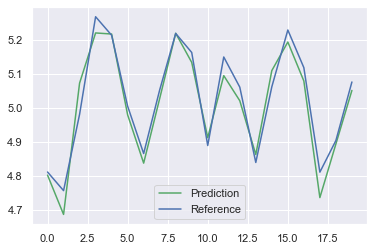

In [170]:
plt.plot(np.array(pred_list_1[-20:])*1, 'g')
plt.plot(np.array(y_list_1[-20:])*1, 'b')
plt.legend(['Prediction','Reference'])
plt.gca()#.set_ylim(49,53)

<AxesSubplot:>

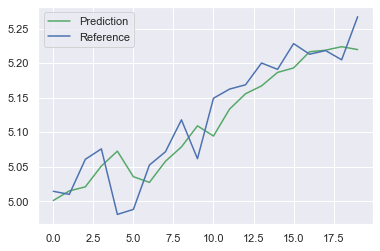

In [171]:
plt.plot(np.array(pred_list_2[-20:])*1, 'g')
plt.plot(np.array(y_list_2[-20:])*1, 'b')
plt.legend(['Prediction','Reference'])
plt.gca()#.set_ylim(0,6)

In [172]:
y_all = y_test[:30].tolist() + y_list_2[-20:]
pred_all = y_test[:30].tolist() + pred_list_2[-20:]

<AxesSubplot:>

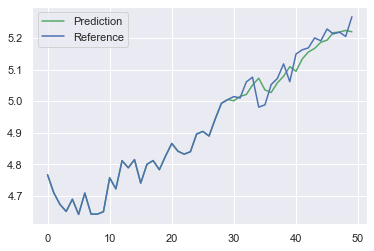

In [173]:
plt.plot(np.array(pred_all)*1, 'g')
plt.plot(np.array(y_all)*1, 'b')
plt.legend(['Prediction','Reference'])
plt.gca()#.set_ylim(0,6)

In [174]:
Ind2Ind10_mse = mean_squared_error(pred_list_2[-20:], y_list_2[-20:])
Ind2Ind10_mse_ave = mean_squared_error(pred_list_1, y_list_1)

## 4. Ind2Ind30

In [175]:
X = torch.zeros([len(date_list)])
y = torch.zeros([len(date_list)])

In [176]:
for i in range(len(date_list)):
    X[i] = torch.tensor(CAC40.loc[(CAC40['Date']==date_list[i])]['Opening Price_G'].unique(), dtype=torch.float)
    y[i] = torch.tensor(CAC40.loc[(CAC40['Date']==date_list[i])]['Opening Price_G'].unique(), dtype=torch.float)

In [177]:
y = y/1000

In [178]:
X_train = X[0:411]
X_val = X[411:461]
X_test = X[461:511]
y_train = y[0:411]
y_val = y[411:461]
y_test = y[461:511]

In [179]:
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = torch.tensor(scaler.fit_transform(X_train.reshape(-1, 1)), dtype=torch.float)
X_val = torch.tensor(scaler.transform(X_val.reshape(-1, 1)), dtype=torch.float)
X_test = torch.tensor(scaler.transform(X_test.reshape(-1, 1)), dtype=torch.float)

In [180]:
seq_len = seq_len_longer
X_train_dataset = []
X_val_dataset = []
X_test_dataset = []
y_train_dataset = []
y_val_dataset = []
y_test_dataset = []
for i in range(seq_len,len(X_train)):
    X_train_dataset.append(X_train[i-seq_len:i])  
    y_train_dataset.append(y_train[i])       
for i in range(seq_len,len(X_val)):
    X_val_dataset.append(X_val[i-seq_len:i])   
    y_val_dataset.append(y_val[i])        
for i in range(seq_len,len(X_val)):              
    X_test_dataset.append(X_test[i-seq_len:i])   
    y_test_dataset.append(y_test[i])        

In [181]:
train_dataset = CustomDataset(X_train_dataset, y_train_dataset)
val_dataset = CustomDataset(X_val_dataset, y_val_dataset)
test_dataset = CustomDataset(X_test_dataset, y_test_dataset)

In [182]:
batch_size = 4
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)    
test_dataloader_NS = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)    

In [183]:
model = RNN(emb_dim=1).to(device)
optimizer = optim.Adam(model.parameters())#, lr = 0.1)

In [184]:
epoch = 20
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []
for i in range(epoch):
    print(f'epoch: {i+1}/{epoch}')
    train_loss = train(train_dataloader, model, loss_fn, optimizer)    
    val_loss = val(val_dataloader, model, loss_fn)                      
    train_loss_list.append(train_loss)
    #train_acc_list.append(train_acc)
    val_loss_list.append(val_loss)
    #val_acc_list.append(val_acc)
print("Done!")

epoch: 1/20
loss: 29.335611  [    0/  381]
loss: 5.648057  [   40/  381]
loss: 0.365181  [   80/  381]
loss: 0.151487  [  120/  381]
loss: 0.030532  [  160/  381]
loss: 0.010425  [  200/  381]
loss: 0.013281  [  240/  381]
loss: 0.005440  [  280/  381]
loss: 0.021108  [  320/  381]
loss: 0.015162  [  360/  381]
Avg loss: 0.138777 

epoch: 2/20
loss: 0.028109  [    0/  381]
loss: 0.003889  [   40/  381]
loss: 0.052540  [   80/  381]
loss: 0.018783  [  120/  381]
loss: 0.018891  [  160/  381]
loss: 0.011821  [  200/  381]
loss: 0.002461  [  240/  381]
loss: 0.015489  [  280/  381]
loss: 0.008927  [  320/  381]
loss: 0.009215  [  360/  381]
Avg loss: 0.141275 

epoch: 3/20
loss: 0.018233  [    0/  381]
loss: 0.035592  [   40/  381]
loss: 0.014118  [   80/  381]
loss: 0.026624  [  120/  381]
loss: 0.007795  [  160/  381]
loss: 0.027196  [  200/  381]
loss: 0.046994  [  240/  381]
loss: 0.011068  [  280/  381]
loss: 0.009334  [  320/  381]
loss: 0.005558  [  360/  381]
Avg loss: 0.150896 



<AxesSubplot:xlabel='epochs'>

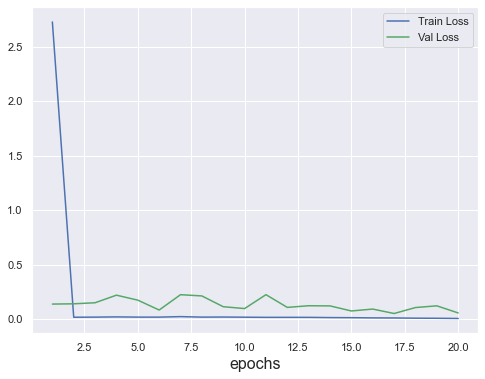

In [185]:
i = 0         
sns.set()
plt.figure(figsize=(8,6))
#plt.plot(range(1,epoch+1), train_acc_log[i], 'orange')
plt.plot(range(1,epoch+1), train_loss_list, 'b')
#plt.plot(range(1,epoch+1), val_acc_log[i], 'r')
plt.plot(range(1,epoch+1), val_loss_list, 'g')
plt.xlabel('epochs',fontsize=16)
plt.legend(['Train Loss','Val Loss'])
plt.grid(True)
plt.gca()#.set_ylim(0,5)

In [186]:
pred_list_1 = []
y_list_1 = []
model.eval()
with torch.no_grad():
    for batch, (X, y) in enumerate(test_dataloader):
        X, y = X.to(device), y
        pred = model(X)
        pred_list_1 = pred_list_1 + pred.cpu().detach().numpy().reshape(pred.shape[0]).tolist()
        y_list_1 = y_list_1 + y.numpy().tolist()
        #predicted = pred.argmax(axis=1)
        #total += y.shape[0]
        #correct += (predicted == y).sum().item()

In [187]:
pred_list_2 = []
y_list_2 = []
model.eval()
with torch.no_grad():
    for batch, (X, y) in enumerate(test_dataloader_NS):
        X, y = X.to(device), y
        pred = model(X)
        pred_list_2 = pred_list_2 + pred.cpu().detach().numpy().reshape(pred.shape[0]).tolist()
        y_list_2 = y_list_2 + y.numpy().tolist()
        #predicted = pred.argmax(axis=1)
        #total += y.shape[0]
        #correct += (predicted == y).sum().item()

<AxesSubplot:>

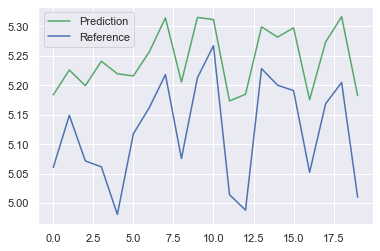

In [188]:
plt.plot(np.array(pred_list_1[-20:])*1, 'g')
plt.plot(np.array(y_list_1[-20:])*1, 'b')
plt.legend(['Prediction','Reference'])
plt.gca()#.set_ylim(49,53)

<AxesSubplot:>

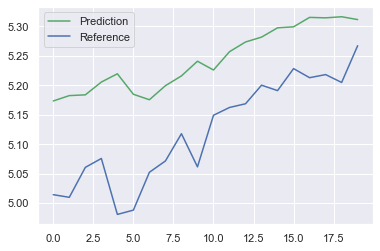

In [189]:
plt.plot(np.array(pred_list_2[-20:])*1, 'g')
plt.plot(np.array(y_list_2[-20:])*1, 'b')
plt.legend(['Prediction','Reference'])
plt.gca()#.set_ylim(0,6)

In [190]:
y_all = y_test[:30].tolist() + y_list_2[-20:]
pred_all = y_test[:30].tolist() + pred_list_2[-20:]

<AxesSubplot:>

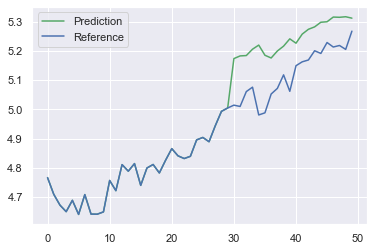

In [191]:
plt.plot(np.array(pred_all)*1, 'g')
plt.plot(np.array(y_all)*1, 'b')
plt.legend(['Prediction','Reference'])
plt.gca()#.set_ylim(0,6)

In [192]:
Ind2Ind30_mse = mean_squared_error(pred_list_2[-20:], y_list_2[-20:])
Ind2Ind30_mse_ave = mean_squared_error(pred_list_1, y_list_1)

## 5. Stk2Ind1

In [193]:
X = torch.zeros([len(date_list),40])
y = torch.zeros([len(date_list)])

In [194]:
for i in range(len(date_list)):
    X[i] = torch.tensor(CAC40.loc[(CAC40['Date']==date_list[i])]['Opening Price_P'].to_numpy(), dtype=torch.float)
    y[i] = torch.tensor(CAC40.loc[(CAC40['Date']==date_list[i])]['Opening Price_G'].unique(), dtype=torch.float)

In [195]:
y = y/1000

In [196]:
X_train = X[0:411]
X_val = X[411:461]
X_test = X[461:511]
y_train = y[0:411]
y_val = y[411:461]
y_test = y[461:511]

In [197]:
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = torch.tensor(scaler.fit_transform(X_train), dtype=torch.float)#.squeeze()
X_val = torch.tensor(scaler.transform(X_val), dtype=torch.float)#.squeeze()
X_test = torch.tensor(scaler.transform(X_test), dtype=torch.float)#.squeeze()

In [198]:
seq_len = seq_len_shorter
X_train_dataset = []
X_val_dataset = []
X_test_dataset = []
y_train_dataset = []
y_val_dataset = []
y_test_dataset = []
for i in range(seq_len,len(X_train)):
    X_train_dataset.append(X_train[i-seq_len:i])  
    y_train_dataset.append(y_train[i])        
for i in range(seq_len,len(X_val)):
    X_val_dataset.append(X_val[i-seq_len:i])   
    y_val_dataset.append(y_val[i])       
for i in range(seq_len,len(X_val)):              
    X_test_dataset.append(X_test[i-seq_len:i])   
    y_test_dataset.append(y_test[i])        

In [199]:
train_dataset = CustomDataset(X_train_dataset, y_train_dataset)
val_dataset = CustomDataset(X_val_dataset, y_val_dataset)
test_dataset = CustomDataset(X_test_dataset, y_test_dataset)

In [200]:
batch_size = 4
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)    
test_dataloader_NS = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)    

In [201]:
model = RNN(emb_dim=40).to(device)
optimizer = optim.Adam(model.parameters())#, lr = 0.1)

In [202]:
epoch = 20
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []
for i in range(epoch):
    print(f'epoch: {i+1}/{epoch}')
    train_loss = train(train_dataloader, model, loss_fn, optimizer)    
    val_loss = val(val_dataloader, model, loss_fn)                      
    train_loss_list.append(train_loss)
    #train_acc_list.append(train_acc)
    val_loss_list.append(val_loss)
    #val_acc_list.append(val_acc)
print("Done!")

epoch: 1/20
loss: 28.243397  [    0/  410]
loss: 21.563061  [   40/  410]
loss: 13.885008  [   80/  410]
loss: 5.520741  [  120/  410]
loss: 0.331426  [  160/  410]
loss: 0.774516  [  200/  410]
loss: 0.184283  [  240/  410]
loss: 0.093135  [  280/  410]
loss: 0.074340  [  320/  410]
loss: 0.088756  [  360/  410]
loss: 0.317436  [  400/  410]
Avg loss: 5.022303 

epoch: 2/20
loss: 0.183257  [    0/  410]
loss: 0.024057  [   40/  410]
loss: 0.048521  [   80/  410]
loss: 0.046237  [  120/  410]
loss: 0.377128  [  160/  410]
loss: 0.288404  [  200/  410]
loss: 0.418152  [  240/  410]
loss: 0.050657  [  280/  410]
loss: 0.214625  [  320/  410]
loss: 0.189550  [  360/  410]
loss: 0.029540  [  400/  410]
Avg loss: 4.693779 

epoch: 3/20
loss: 0.112254  [    0/  410]
loss: 0.172197  [   40/  410]
loss: 0.148875  [   80/  410]
loss: 0.170650  [  120/  410]
loss: 0.075551  [  160/  410]
loss: 0.068911  [  200/  410]
loss: 0.243441  [  240/  410]
loss: 0.037314  [  280/  410]
loss: 0.117680  [  

<AxesSubplot:xlabel='epochs'>

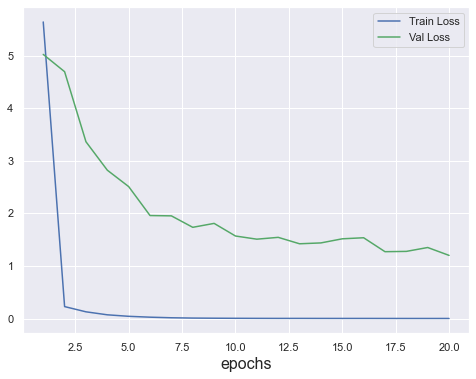

In [203]:
i = 0        
sns.set()
plt.figure(figsize=(8,6))
#plt.plot(range(1,epoch+1), train_acc_log[i], 'orange')
plt.plot(range(1,epoch+1), train_loss_list, 'b')
#plt.plot(range(1,epoch+1), val_acc_log[i], 'r')
plt.plot(range(1,epoch+1), val_loss_list, 'g')
plt.xlabel('epochs',fontsize=16)
plt.legend(['Train Loss','Val Loss'])
plt.grid(True)
plt.gca()#.set_ylim(0,5)

In [204]:
pred_list_1 = []
y_list_1 = []
model.eval()
with torch.no_grad():
    for batch, (X, y) in enumerate(test_dataloader):
        X, y = X.to(device), y
        pred = model(X)
        pred_list_1 = pred_list_1 + pred.cpu().detach().numpy().reshape(pred.shape[0]).tolist()
        y_list_1 = y_list_1 + y.numpy().tolist()
        #predicted = pred.argmax(axis=1)
        #total += y.shape[0]
        #correct += (predicted == y).sum().item()

In [205]:
pred_list_2 = []
y_list_2 = []
model.eval()
with torch.no_grad():
    for batch, (X, y) in enumerate(test_dataloader_NS):
        X, y = X.to(device), y
        pred = model(X)
        pred_list_2 = pred_list_2 + pred.cpu().detach().numpy().reshape(pred.shape[0]).tolist()
        y_list_2 = y_list_2 + y.numpy().tolist()
        #predicted = pred.argmax(axis=1)
        #total += y.shape[0]
        #correct += (predicted == y).sum().item()

<AxesSubplot:>

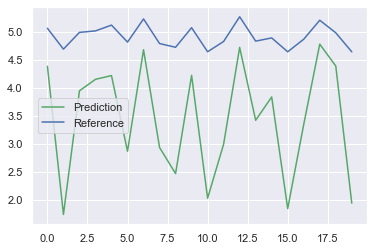

In [206]:
plt.plot(np.array(pred_list_1[-20:])*1, 'g')
plt.plot(np.array(y_list_1[-20:])*1, 'b')
plt.legend(['Prediction','Reference'])
plt.gca()#.set_ylim(49,53)

<AxesSubplot:>

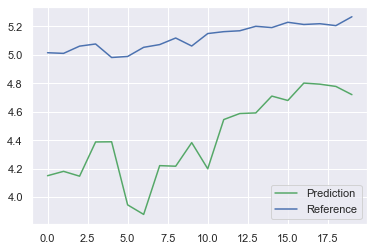

In [207]:
plt.plot(np.array(pred_list_2[-20:])*1, 'g')
plt.plot(np.array(y_list_2[-20:])*1, 'b')
plt.legend(['Prediction','Reference'])
plt.gca()#.set_ylim(0,6)

In [208]:
y_all = y_test[:30].tolist() + y_list_2[-20:]     
pred_all = y_test[:30].tolist() + pred_list_2[-20:]

<AxesSubplot:>

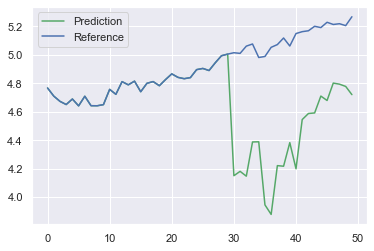

In [209]:
plt.plot(np.array(pred_all)*1, 'g')
plt.plot(np.array(y_all)*1, 'b')
plt.legend(['Prediction','Reference'])
plt.gca()#.set_ylim(0,6)

In [210]:
Stk2Ind1_mse = mean_squared_error(pred_list_2[-20:], y_list_2[-20:])
Stk2Ind1_mse_ave = mean_squared_error(pred_list_1, y_list_1)

## 6. Stk2Ind10

In [211]:
X = torch.zeros([len(date_list),40])
y = torch.zeros([len(date_list)])

In [212]:
for i in range(len(date_list)):
    X[i] = torch.tensor(CAC40.loc[(CAC40['Date']==date_list[i])]['Opening Price_P'].to_numpy(), dtype=torch.float)
    y[i] = torch.tensor(CAC40.loc[(CAC40['Date']==date_list[i])]['Opening Price_G'].unique(), dtype=torch.float)

In [213]:
y = y/1000

In [214]:
X_train = X[0:411]
X_val = X[411:461]
X_test = X[461:511]
y_train = y[0:411]
y_val = y[411:461]
y_test = y[461:511]

In [215]:
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = torch.tensor(scaler.fit_transform(X_train), dtype=torch.float)#.squeeze()
X_val = torch.tensor(scaler.transform(X_val), dtype=torch.float)#.squeeze()
X_test = torch.tensor(scaler.transform(X_test), dtype=torch.float)#.squeeze()

In [216]:
seq_len = seq_len_medium
X_train_dataset = []
X_val_dataset = []
X_test_dataset = []
y_train_dataset = []
y_val_dataset = []
y_test_dataset = []
for i in range(seq_len,len(X_train)):
    X_train_dataset.append(X_train[i-seq_len:i])  
    y_train_dataset.append(y_train[i])        
for i in range(seq_len,len(X_val)):
    X_val_dataset.append(X_val[i-seq_len:i])   
    y_val_dataset.append(y_val[i])        
for i in range(seq_len,len(X_val)):              
    X_test_dataset.append(X_test[i-seq_len:i])   
    y_test_dataset.append(y_test[i])       

In [217]:
train_dataset = CustomDataset(X_train_dataset, y_train_dataset)
val_dataset = CustomDataset(X_val_dataset, y_val_dataset)
test_dataset = CustomDataset(X_test_dataset, y_test_dataset)

In [218]:
batch_size = 4
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)    
test_dataloader_NS = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)    

In [219]:
model = RNN(emb_dim=40).to(device)
optimizer = optim.Adam(model.parameters())#, lr = 0.1)

In [220]:
epoch = 20
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []
for i in range(epoch):
    print(f'epoch: {i+1}/{epoch}')
    train_loss = train(train_dataloader, model, loss_fn, optimizer)    
    val_loss = val(val_dataloader, model, loss_fn)                      
    train_loss_list.append(train_loss)
    #train_acc_list.append(train_acc)
    val_loss_list.append(val_loss)
    #val_acc_list.append(val_acc)
print("Done!")

epoch: 1/20
loss: 29.296640  [    0/  401]
loss: 0.031097  [   40/  401]
loss: 0.008212  [   80/  401]
loss: 0.145631  [  120/  401]
loss: 0.085620  [  160/  401]
loss: 0.023197  [  200/  401]
loss: 0.022359  [  240/  401]
loss: 0.005991  [  280/  401]
loss: 0.003655  [  320/  401]
loss: 0.001402  [  360/  401]
loss: 0.008038  [  100/  401]
Avg loss: 0.034194 

epoch: 2/20
loss: 0.018902  [    0/  401]
loss: 0.005784  [   40/  401]
loss: 0.014869  [   80/  401]
loss: 0.019935  [  120/  401]
loss: 0.003154  [  160/  401]
loss: 0.004443  [  200/  401]
loss: 0.005030  [  240/  401]
loss: 0.008261  [  280/  401]
loss: 0.004918  [  320/  401]
loss: 0.008897  [  360/  401]
loss: 0.002667  [  100/  401]
Avg loss: 0.042185 

epoch: 3/20
loss: 0.008746  [    0/  401]
loss: 0.004526  [   40/  401]
loss: 0.006911  [   80/  401]
loss: 0.011093  [  120/  401]
loss: 0.005825  [  160/  401]
loss: 0.005653  [  200/  401]
loss: 0.012644  [  240/  401]
loss: 0.001561  [  280/  401]
loss: 0.004909  [  32

<AxesSubplot:xlabel='epochs'>

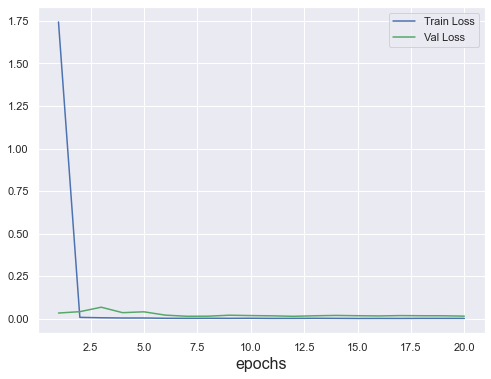

In [221]:
i = 0         
sns.set()
plt.figure(figsize=(8,6))
#plt.plot(range(1,epoch+1), train_acc_log[i], 'orange')
plt.plot(range(1,epoch+1), train_loss_list, 'b')
#plt.plot(range(1,epoch+1), val_acc_log[i], 'r')
plt.plot(range(1,epoch+1), val_loss_list, 'g')
plt.xlabel('epochs',fontsize=16)
plt.legend(['Train Loss','Val Loss'])
plt.grid(True)
plt.gca()#.set_ylim(0,5)

In [222]:
pred_list_1 = []
y_list_1 = []
model.eval()
with torch.no_grad():
    for batch, (X, y) in enumerate(test_dataloader):
        X, y = X.to(device), y
        pred = model(X)
        pred_list_1 = pred_list_1 + pred.cpu().detach().numpy().reshape(pred.shape[0]).tolist()
        y_list_1 = y_list_1 + y.numpy().tolist()
        #predicted = pred.argmax(axis=1)
        #total += y.shape[0]
        #correct += (predicted == y).sum().item()

In [223]:
pred_list_2 = []
y_list_2 = []
model.eval()
with torch.no_grad():
    for batch, (X, y) in enumerate(test_dataloader_NS):
        X, y = X.to(device), y
        pred = model(X)
        pred_list_2 = pred_list_2 + pred.cpu().detach().numpy().reshape(pred.shape[0]).tolist()
        y_list_2 = y_list_2 + y.numpy().tolist()
        #predicted = pred.argmax(axis=1)
        #total += y.shape[0]
        #correct += (predicted == y).sum().item()

<AxesSubplot:>

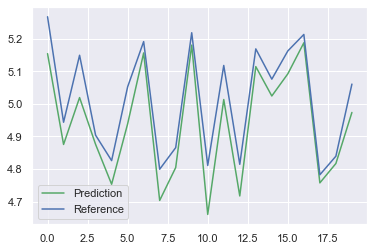

In [224]:
plt.plot(np.array(pred_list_1[-20:])*1, 'g')
plt.plot(np.array(y_list_1[-20:])*1, 'b')
plt.legend(['Prediction','Reference'])
plt.gca()#.set_ylim(49,53)

<AxesSubplot:>

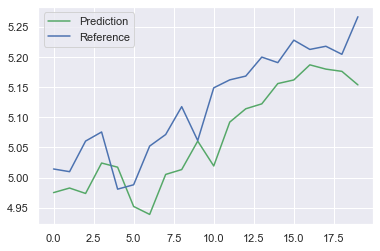

In [225]:
plt.plot(np.array(pred_list_2[-20:])*1, 'g')
plt.plot(np.array(y_list_2[-20:])*1, 'b')
plt.legend(['Prediction','Reference'])
plt.gca()#.set_ylim(0,6)

In [226]:
y_all = y_test[:30].tolist() + y_list_2[-20:]     
pred_all = y_test[:30].tolist() + pred_list_2[-20:]

<AxesSubplot:>

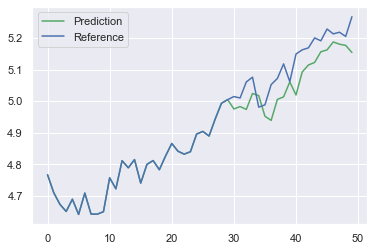

In [227]:
plt.plot(np.array(pred_all)*1, 'g')
plt.plot(np.array(y_all)*1, 'b')
plt.legend(['Prediction','Reference'])
plt.gca()#.set_ylim(0,6)

In [228]:
Stk2Ind10_mse = mean_squared_error(pred_list_2[-20:], y_list_2[-20:])
Stk2Ind10_mse_ave = mean_squared_error(pred_list_1, y_list_1)

## 7. Stk2Ind30

In [229]:
X = torch.zeros([len(date_list),40])
y = torch.zeros([len(date_list)])

In [230]:
for i in range(len(date_list)):
    X[i] = torch.tensor(CAC40.loc[(CAC40['Date']==date_list[i])]['Opening Price_P'].to_numpy(), dtype=torch.float)
    y[i] = torch.tensor(CAC40.loc[(CAC40['Date']==date_list[i])]['Opening Price_G'].unique(), dtype=torch.float)

In [231]:
y = y/1000

In [232]:
X_train = X[0:411]
X_val = X[411:461]
X_test = X[461:511]
y_train = y[0:411]
y_val = y[411:461]
y_test = y[461:511]

In [233]:
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = torch.tensor(scaler.fit_transform(X_train), dtype=torch.float)#.squeeze()
X_val = torch.tensor(scaler.transform(X_val), dtype=torch.float)#.squeeze()
X_test = torch.tensor(scaler.transform(X_test), dtype=torch.float)#.squeeze()

In [234]:
seq_len = seq_len_longer
X_train_dataset = []
X_val_dataset = []
X_test_dataset = []
y_train_dataset = []
y_val_dataset = []
y_test_dataset = []
for i in range(seq_len,len(X_train)):
    X_train_dataset.append(X_train[i-seq_len:i])   
    y_train_dataset.append(y_train[i])       
for i in range(seq_len,len(X_val)):
    X_val_dataset.append(X_val[i-seq_len:i])   
    y_val_dataset.append(y_val[i])        
for i in range(seq_len,len(X_val)):             
    X_test_dataset.append(X_test[i-seq_len:i])  
    y_test_dataset.append(y_test[i])        

In [235]:
train_dataset = CustomDataset(X_train_dataset, y_train_dataset)
val_dataset = CustomDataset(X_val_dataset, y_val_dataset)
test_dataset = CustomDataset(X_test_dataset, y_test_dataset)

In [236]:
batch_size = 4
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)    
test_dataloader_NS = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)    

In [237]:
model = RNN(emb_dim=40).to(device)
optimizer = optim.Adam(model.parameters())#, lr = 0.1)

In [238]:
epoch = 20
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []
for i in range(epoch):
    print(f'epoch: {i+1}/{epoch}')
    train_loss = train(train_dataloader, model, loss_fn, optimizer)    
    val_loss = val(val_dataloader, model, loss_fn)                      
    train_loss_list.append(train_loss)
    #train_acc_list.append(train_acc)
    val_loss_list.append(val_loss)
    #val_acc_list.append(val_acc)
print("Done!")

epoch: 1/20
loss: 28.555695  [    0/  381]
loss: 0.315996  [   40/  381]
loss: 0.052812  [   80/  381]
loss: 0.032354  [  120/  381]
loss: 0.051645  [  160/  381]
loss: 0.014414  [  200/  381]
loss: 0.009059  [  240/  381]
loss: 0.014091  [  280/  381]
loss: 0.018161  [  320/  381]
loss: 0.012592  [  360/  381]
Avg loss: 0.024147 

epoch: 2/20
loss: 0.030042  [    0/  381]
loss: 0.006070  [   40/  381]
loss: 0.009608  [   80/  381]
loss: 0.000592  [  120/  381]
loss: 0.003435  [  160/  381]
loss: 0.005650  [  200/  381]
loss: 0.004467  [  240/  381]
loss: 0.007396  [  280/  381]
loss: 0.005304  [  320/  381]
loss: 0.002038  [  360/  381]
Avg loss: 0.048066 

epoch: 3/20
loss: 0.001776  [    0/  381]
loss: 0.003934  [   40/  381]
loss: 0.002888  [   80/  381]
loss: 0.014152  [  120/  381]
loss: 0.002709  [  160/  381]
loss: 0.003350  [  200/  381]
loss: 0.008854  [  240/  381]
loss: 0.013807  [  280/  381]
loss: 0.009538  [  320/  381]
loss: 0.002604  [  360/  381]
Avg loss: 0.045850 



<AxesSubplot:xlabel='epochs'>

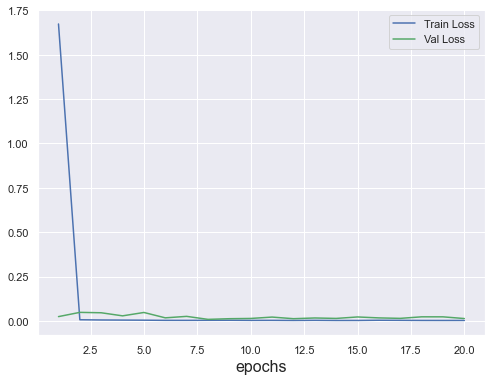

In [239]:
i = 0        
sns.set()
plt.figure(figsize=(8,6))
#plt.plot(range(1,epoch+1), train_acc_log[i], 'orange')
plt.plot(range(1,epoch+1), train_loss_list, 'b')
#plt.plot(range(1,epoch+1), val_acc_log[i], 'r')
plt.plot(range(1,epoch+1), val_loss_list, 'g')
plt.xlabel('epochs',fontsize=16)
plt.legend(['Train Loss','Val Loss'])
plt.grid(True)
plt.gca()#.set_ylim(0,5)

In [240]:
pred_list_1 = []
y_list_1 = []
model.eval()
with torch.no_grad():
    for batch, (X, y) in enumerate(test_dataloader):
        X, y = X.to(device), y
        pred = model(X)
        pred_list_1 = pred_list_1 + pred.cpu().detach().numpy().reshape(pred.shape[0]).tolist()
        y_list_1 = y_list_1 + y.numpy().tolist()
        #predicted = pred.argmax(axis=1)
        #total += y.shape[0]
        #correct += (predicted == y).sum().item()

In [241]:
pred_list_2 = []
y_list_2 = []
model.eval()
with torch.no_grad():
    for batch, (X, y) in enumerate(test_dataloader_NS):
        X, y = X.to(device), y
        pred = model(X)
        pred_list_2 = pred_list_2 + pred.cpu().detach().numpy().reshape(pred.shape[0]).tolist()
        y_list_2 = y_list_2 + y.numpy().tolist()
        #predicted = pred.argmax(axis=1)
        #total += y.shape[0]
        #correct += (predicted == y).sum().item()

<AxesSubplot:>

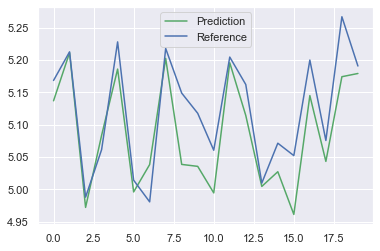

In [242]:
plt.plot(np.array(pred_list_1[-20:])*1, 'g')
plt.plot(np.array(y_list_1[-20:])*1, 'b')
plt.legend(['Prediction','Reference'])
plt.gca()#.set_ylim(49,53)

<AxesSubplot:>

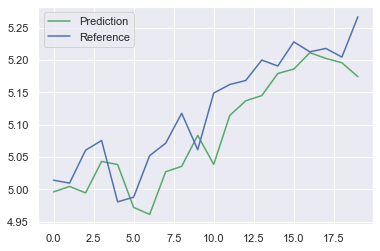

In [243]:
plt.plot(np.array(pred_list_2[-20:])*1, 'g')
plt.plot(np.array(y_list_2[-20:])*1, 'b')
plt.legend(['Prediction','Reference'])
plt.gca()#.set_ylim(0,6)

In [244]:
y_all = y_test[:30].tolist() + y_list_2[-20:]    
pred_all = y_test[:30].tolist() + pred_list_2[-20:]

<AxesSubplot:>

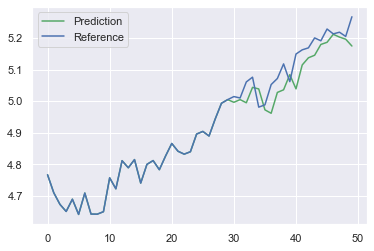

In [245]:
plt.plot(np.array(pred_all)*1, 'g')
plt.plot(np.array(y_all)*1, 'b')
plt.legend(['Prediction','Reference'])
plt.gca()#.set_ylim(0,6)

In [246]:
Stk2Ind30_mse = mean_squared_error(pred_list_2[-20:], y_list_2[-20:])
Stk2Ind30_mse_ave = mean_squared_error(pred_list_1, y_list_1)

In [247]:
print(Ind2Ind1_mse, Ind2Ind10_mse, Ind2Ind30_mse, Stk2Ind1_mse, Stk2Ind10_mse, Stk2Ind30_mse)

0.0016774474040857968 0.0013339016484110288 0.016948540545035938 0.5455168107408384 0.004766453060130971 0.0028035363465050978


## 8. Discussion and Reflection

In [248]:
CAC40_PX1 = CAC40.drop(columns=cols_final[1:10]).copy()     
CAC40_PX1.drop_duplicates(inplace=True)                     
CAC40_PX1 = CAC40_PX1.reset_index(drop=True)                
col_order = ['Date','Ticker','Opening Price','Highest Price','Lowest Price','Closing Price','Trading Volume','Gtrends','Name','ISIN'] 
#CAC40_Comp.columns = col_order                             
CAC40_PX1.columns = col_order

Text(0, 0.5, 'Volume and Trends')

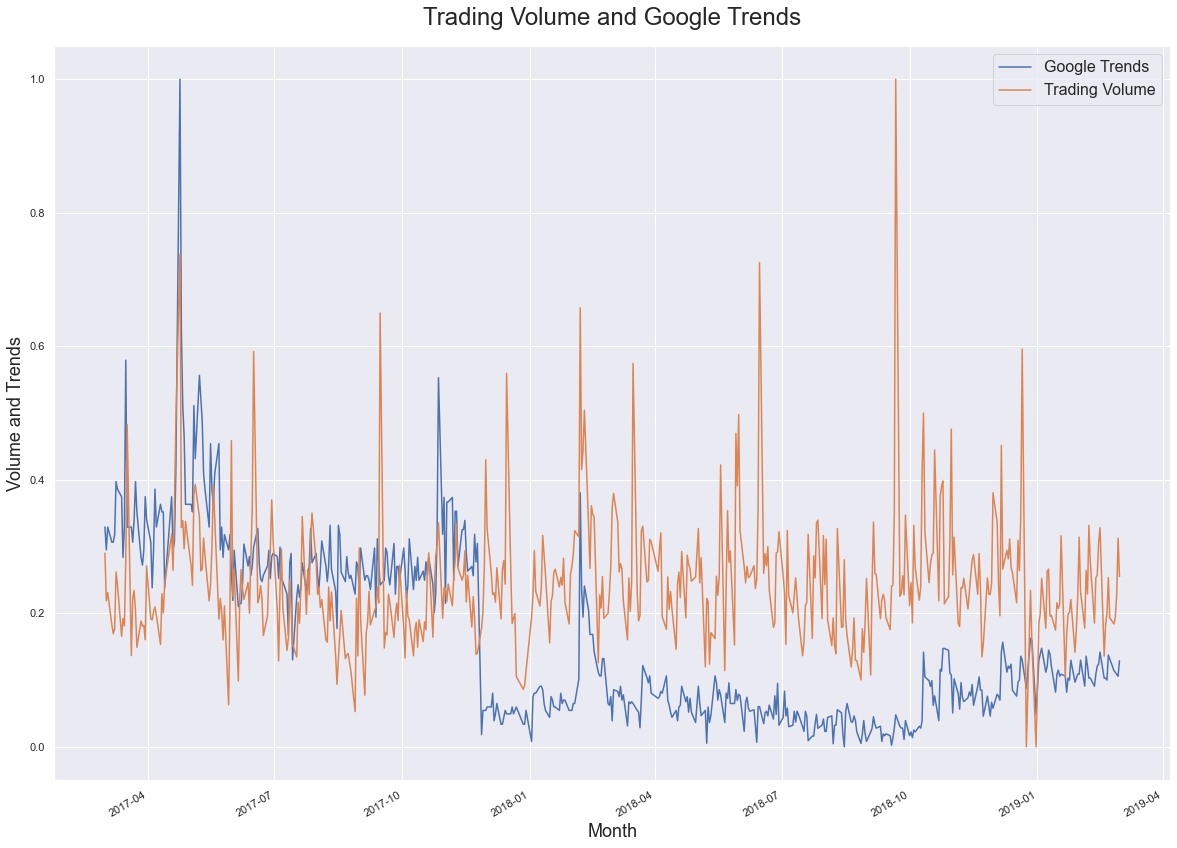

In [249]:
scaler = MinMaxScaler()                                               
min_max_vol = scaler.fit_transform(np.array(CAC40_PX1['Trading Volume']).reshape(-1,1))     
min_max_g = scaler.fit_transform(np.array(CAC40_PX1['Gtrends']).reshape(-1,1))
min_max_vol = min_max_vol.ravel()                                     
min_max_g = min_max_g.ravel()                                        
g_trade_vol = pd.DataFrame({'Date':np.array(CAC40_PX1['Date']),'Gtrends':min_max_g,'Trading Volume':min_max_vol},index=range(511))
g_trade_vol.plot(x='Date',figsize=(20,15))                            
plt.title('Trading Volume and Google Trends',fontsize=24,y=1.02)   
plt.legend(['Google Trends','Trading Volume'],fontsize=16)
plt.xlabel('Month',fontsize=18)
plt.ylabel('Volume and Trends',fontsize=18)

In [250]:
CAC40_Comp = CAC40.iloc[:,0:10].copy()                     
CAC40_Comp = CAC40_Comp.reset_index(drop=True)             
CAC40_PX1 = CAC40.drop(columns=cols_final[1:10]).copy()    
CAC40_PX1.drop_duplicates(inplace=True)                     
CAC40_PX1 = CAC40_PX1.reset_index(drop=True)                
col_order = ['Date','Ticker','Opening Price','Highest Price','Lowest Price','Closing Price','Trading Volume','Gtrends','Name','ISIN'] 
CAC40_Comp.columns = col_order                              
CAC40_PX1.columns = col_order

CAC40_All = CAC40_Comp.append(CAC40_PX1)                   
CAC40_All = CAC40_All.sort_values(by=['Date','Ticker'])     
CAC40_All = CAC40_All.reset_index(drop=True)               

In [251]:
CAC40_All_price_arr = np.array(CAC40_All[col_order[2:6]])   
CAC40_All_mean_arr = np.mean(CAC40_All_price_arr,axis=1)     
CAC40_All_mean_df = pd.DataFrame({'Date':CAC40_All['Date'],'Ticker':CAC40_All['Ticker'],'Mean':CAC40_All_mean_arr})

In [252]:
# create a DataFrame for plotting
mean_df = pd.DataFrame()                           
for i in CAC40_All_mean_df['Ticker'].unique():     
    mean_df[i] = np.array(CAC40_All_mean_df[CAC40_All_mean_df['Ticker']==i]['Mean'])           
mean_df.insert(40,'PX1',mean_df.pop('PX1'))          


Text(201.5, 0.5, 'Tickers')

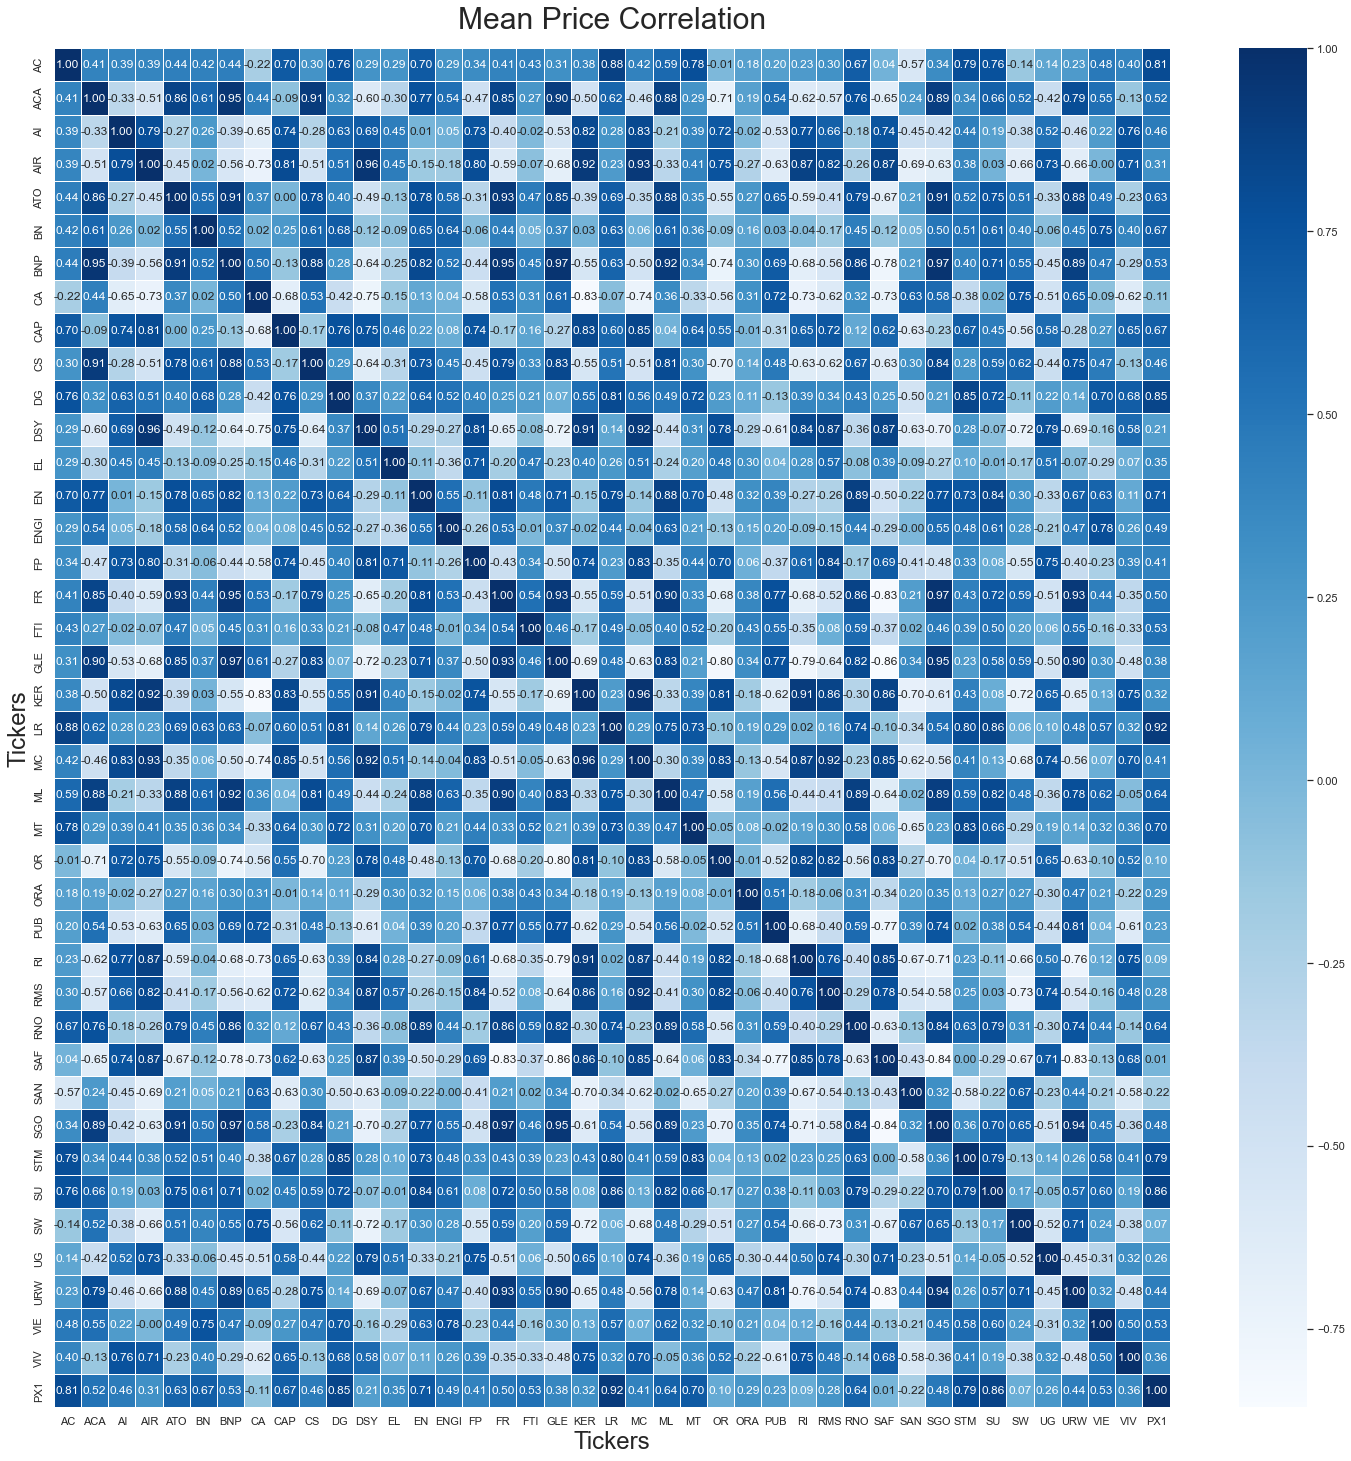

In [253]:
plt.figure(figsize=(25,25))                                                  
sns.heatmap(mean_df.corr(),annot=True,fmt ='.2f',linewidths =0.5, cmap = 'Blues')          
plt.title('Mean Price Correlation',fontsize=30,y=1.01)                      
plt.xlabel('Tickers',fontsize=24)
plt.ylabel('Tickers',fontsize=24)

***
CHEN Chen a1819099, 20-Nov-2022